In [5]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

In [7]:
import evaluate

wer  = evaluate.load('wer')

In [8]:
atco_asr_data = load_dataset('parquet',data_files="validation-00000-of-00002-7a5ea3756991bf72.parquet")

# What frequencies are present in the dataset

100%|██████████| 1013/1013 [00:00<00:00, 2707.77it/s]


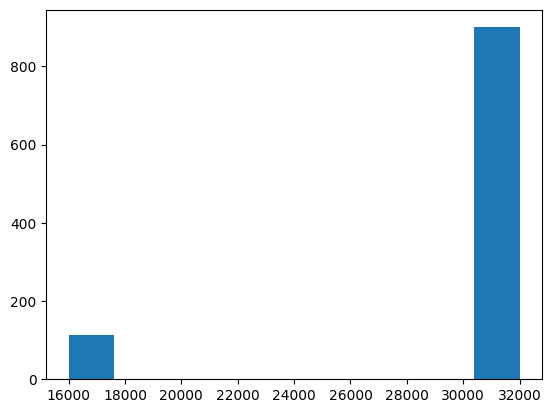

In [14]:
sr_list=[]
for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
    sample_rate=sample['audio']['sampling_rate']
    sr_list.append(sample_rate)

plt.hist(sr_list)
plt.show()


 As there is 32000Hz is also present in the dataset, we will have to downsample the audio into 16000Hz

In [ ]:
from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [9]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [ ]:
predictions=[]
references=[]

for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
    audio=sample['audio']['array']
    sample_rate=sample['audio']['sampling_rate']
    text=sample['text']

    audio = down_sample_audio(audio, sample_rate) # downsample the audio to 16000Hz for WHISPER

    input_features = feature_extractor(
    raw_speech=audio,
    sampling_rate=16000,
    return_tensors='pt',
    padding=True).input_features

    # Generate predictions with no gradient computation
    with torch.no_grad():
        op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

    # Decode predictions
    text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

    # Append batch predictions and references to the respective lists
    predictions.extend(text_preds)
    references.extend([text])

    # break


100%|██████████| 1013/1013 [00:00<00:00, 3011.94it/s]


In [34]:
len(predictions),len(references)

(1013, 1013)

In [35]:
wer.compute(predictions=predictions, references=references) * 100

90.40845187588387

In [36]:
text

'algerie two zero seven three proceed direct to trasadingen and continue climb to level two seven zero '

In [37]:
text_preds

[" I'll sherry 2073 Proceed direct to traceting and continue climb to level 270."]